In [257]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
sx = qt.sigmax();sy = qt.sigmay(); sz = qt.sigmaz(); s0 = qt.qeye(2); sm = qt.sigmam(); sp = qt.sigmap()

In [323]:


class OU_process():
    def __init__(self, sig, tc):
        self.x = sig*np.random.normal(0,1)
        self.sig = sig
        self.tc = tc
    
    def update(self, dt):
        n = np.random.normal(0,1)
        self.x = self.x*(np.exp(-dt/self.tc)) + +np.sqrt(1-np.exp(-2*dt/self.tc))*self.sig*n

    def get_x(self):
        return self.x

class sensor_dot():
    def __init__(self, gmax, T=100, dE = 1e3):
        self.gmax = gmax
        self.T = T #mK
        self.dE = 1e3
        self.kb = 0.08617 #mueV/mK
        self.eps0 = self.kb*self.T

    def get_R(self, eps):
        G = self.gmax*self.dE/self.kb/self.T*np.cosh((eps+self.eps0)/2/self.kb/self.T)**(-2)
        return 1/G








class rlc_ode():
    def __init__(self, R, L, C, wd, Ad, noise, sensor_dot, dt = None, bit = 1, deps = 1):   
        self.R = R
        self.L = L
        self.C = C
        self.wd = wd
        self.Ad = Ad
        self.dt = dt
        self.noise = noise
        self.bit = bit
        self.deps = deps
        self.sd = sensor_dot

    def fdx(self, x, t, eps):
        R = self.sd.get_R(eps)
        Vt = self.Ad*np.exp(-1.j*self.wd*t)
        return np.array([x[1], -R/self.L*x[1] -x[0]/self.L/self.C + Vt/self.L/self.C ])

    def RK4_step(self, x, t):

        l1 = self.fdx(x, t, self.noise.get_x()+self.bit*self.deps)
        self.noise.update(self.dt/2)
        l2 = self.fdx(x + l1 * self.dt / 2, t +self.dt/2,self.noise.get_x() + self.bit*self.deps)
        l3 = self.fdx(x+ l2 * self.dt / 2, t+self.dt/2,self.noise.get_x()+self.bit*self.deps)
        self.noise.update(self.dt/2)
        l4 = self.fdx(x + l3 * self.dt, t,self.noise.get_x()+self.bit*self.deps)
        return x + self.dt * (l1 + 2 * l2 + 2 * l3 + l4) / 6, t

    def solve_ode(self, x0, times):
        di = np.zeros(len(times), dtype=complex)
        i = np.zeros(len(times), dtype=complex)
        self.dt = times[1]-times[0]
        i[0] = x0[0]
        di[0] = x0[1]
        x = x0
        for n,t in enumerate(times[:-1]):
            x,t0  = self.RK4_step(x, t)
            i[n+1] = x[0]
            di[n+1] = x[1]
        return i, di

    #def get_reflection(self, vin, vout):
   #    return vout/vin
    

In [339]:

Lc = 800*1e-9
Rs1 = 50*1e3
Rs2 = 60*1e3
Cp = 0.6*1e-12
Rc = 10*1e6
Rl = 20
Req1 = Rs1 + Rc
Req2 = Rs2 + Rc
R1 = Lc/(Cp*Rs1)
R2 = Lc/(Cp*Rs2)

sig = 5*1e1
tc = 1e-6

noise = OU_process(sig = sig, tc =tc)
sd = sensor_dot(gmax=1e-6, T=100, dE = 1e3)
rlcS = rlc_ode(R=R1, L=Lc, C=Cp, wd=1/np.sqrt(Lc*Cp), Ad=1, noise = noise, sensor_dot=sd, bit=1)
rlcT = rlc_ode(R=R2, L=Lc, C=Cp, wd=1/np.sqrt(Lc*Cp), Ad=1, noise = noise, sensor_dot=sd,bit=-1)

In [340]:
sd.get_R(0)

10956.862915101476

In [341]:
Req = R1 + Rc
wd = 1/np.sqrt(Lc*Cp)
Zl = 1j*wd*Lc + Rl + Req/(1+1j*wd*Req*Cp)
Zl = 1j*wd*Lc + Rl + Req*(1-1j*wd*Req*Cp)/(1+wd**2*Req**2*Cp**2)

In [342]:
Zl

(20.13333297600096+1.5395924947370077e-05j)

In [347]:
times = np.linspace(0,5*1e-7,100001)
i1, di = rlcS.solve_ode([0,0], times)
i2, di = rlcT.solve_ode([0,0], times)
#gam = rlc.get_reflection(rlc.Ad*np.exp(1j*rlc.wd*times), v)

#plt.plot(times, rlc.Ad*np.cos(rlc.wd*times))

0.10701262820431731
0.16030773692054723
0.26258443705898316
0.45294593347377643
0.7390664721407924
0.7574589256810712
0.7923501253461761
0.9156752538522954
1.100004232066576
1.251719971904404
1.298819346118918
1.3789364139996607
1.3431601593170188
1.2557731533532808
1.4376698978666647
1.3975901159572341
1.4785965304501063
1.4802924946032958
1.4312148094906918
1.4796206409536794
1.4472021377223439
1.5448202911946234
1.5757849760273197
1.516760928750484
1.5636679918929945
1.5512152163326864
1.5359730624047128
1.7578838711874125
1.613493982559417
1.410472755452841
1.4913542819373182
1.5448027849311918
1.5512580230335422
1.257451397685032
1.275732823863402
1.4077992028536133
1.2248098985559488
1.1510449953438127
1.4371563490166817
1.1272105567771626
1.2900842174383405
1.3822048834706417
1.3842827194834555
1.5980765888443234
1.9210276463466514
2.0927391961296498
1.9259375549019764
2.025705349568323
1.8891952128096077
1.8197158100813218
1.894309963170684
1.8758618283111956
2.104115019946019


/var/folders/wj/x78z9z710q7csr068fhd10bxk7mx3x/T/ipykernel_44755/526018082.py:49: RuntimeWarning: overflow encountered in cdouble_scalars
  return np.array([x[1], -R/self.L*x[1] -x[0]/self.L/self.C + Vt/self.L/self.C ])
/var/folders/wj/x78z9z710q7csr068fhd10bxk7mx3x/T/ipykernel_44755/526018082.py:60: RuntimeWarning: overflow encountered in multiply
  return x + self.dt * (l1 + 2 * l2 + 2 * l3 + l4) / 6, t
/var/folders/wj/x78z9z710q7csr068fhd10bxk7mx3x/T/ipykernel_44755/526018082.py:60: RuntimeWarning: invalid value encountered in add
  return x + self.dt * (l1 + 2 * l2 + 2 * l3 + l4) / 6, t


-54.443100814201024
-54.606389933617045
-54.47138512762207
-54.51926522447796
-54.46881147932245
-54.536398629223854
-54.284206802468844
-54.318704826572564
-54.51527611323936
-54.79131182185038
-54.70491807468145
-54.63402260596639
-54.604926330072054
-54.60721043364375
-54.534352597231674
-54.497229615453534
-54.55127814159353
-54.33327837555728
-54.33060159798438
-54.351507331472874
-54.36223427601002
-54.53951363393318
-54.571016668353835
-54.283625871301155
-54.20927831680426
-54.13387260314027
-54.119120821845016
-53.986327370857516
-53.72516205389632
-53.918253243108644
-53.72216473510517
-53.876102362252915
-53.847764379189705
-53.91137823142438
-54.02368091681613
-53.99441438960107
-54.12291493668036
-53.87432392243338
-53.903071289852576
-54.00082950239495
-53.781406245802195
-53.86274302444996
-53.74613257642732
-54.01003838403212
-54.14590175348885
-54.10310400345422
-53.98202062953614
-53.868465359309866
-53.80994867770293
-53.90923894408223
-53.787164624817436
-53.7508626

(4.9e-07, 5e-07)

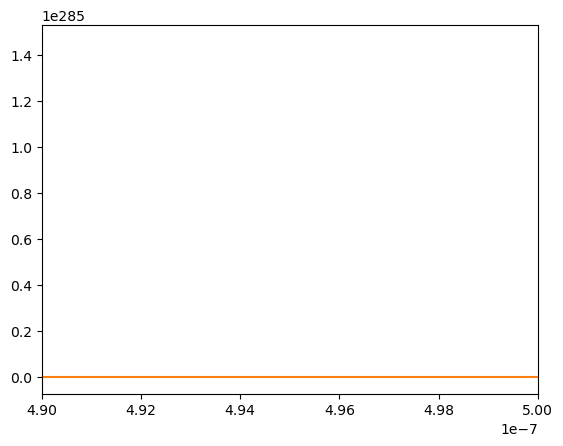

In [345]:
plt.plot(times,np.real(i1))
plt.plot(times,np.real(i2))
plt.xlim(0.9*1e-7+4*1e-7,1e-7+4*1e-7)


In [209]:
i1

array([ 0.00000000e+00+0.00000000e+00j,  1.04154370e-04-5.01136435e-07j,
        4.16542987e-04-3.50747919e-06j, ...,
       -5.63747058e+01-1.24540984e+01j, -5.65485868e+01-1.16391306e+01j,
       -5.67106870e+01-1.08217380e+01j])

In [228]:
print(np.max(i1))
print(np.max(i2))

(66.6299852421323-0.010008862837423749j)
(88.71438928986478+0.28518944386785705j)


In [ ]:

def next_OU_step(x, tc, sig, dt):
    n = np.random.normal(0,1)
    return x*(np.exp(-dt/tc)) + +np.sqrt(1-np.exp(-2*dt/tc))*sig*n

def OU_process(x0, tau, sig, tc, n_steps):
    x = np.zeros(n_steps)
    x[0] = x0
    for i in range(1, n_steps):
        x[i] = next_OU_step(x[i-1], tau, sig, tc)
    return x

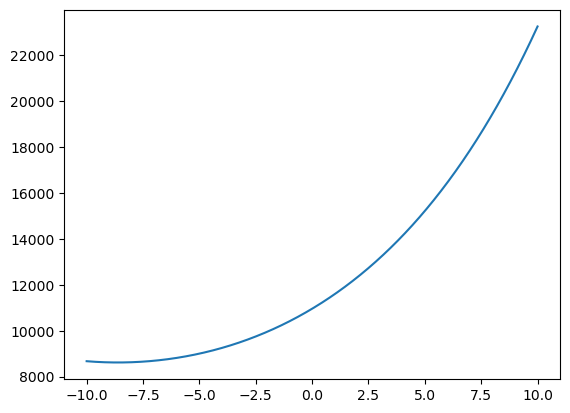

In [304]:
sd = sensor_dot(gmax=1e-6, T=100, dE = 1e3)

eps = np.linspace(-10,1e1,1001)

plt.plot(eps, sd.get_R(eps))